<a href="https://colab.research.google.com/github/pthavarasa/2d-platformer-game-python-3/blob/master/Vehicle_Image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP 2 : Classification d'image
Dans cet exercice, nous allons réaliser un modèle de classification
d'images à l'aide de la bibliothèque Keras. Le jeu de données à utiliser est
libre, mais il devra contenir au minimum deux classes. De plus, une
explication devra être fournie dans votre fichier Readme. En ce qui
concerne le nombre d'échantillons, je vous recommande d'avoir un peu
plus de 100 images par classe.

## 2.1 Téléchargez et installez les packages et leurs dépendances.
* `!pip install mega.py` : cette commande utilise le gestionnaire de paquets pip pour installer la bibliothèque `mega.py`. Cette bibliothèque fournit une interface Python pour travailler avec MEGA, un service de stockage en nuage et d'hébergement de fichiers. Il vous permet d'interagir avec l'API de MEGA et d'effectuer diverses opérations sur les fichiers.

* `!sudo apt-get install unzip` : cette commande utilise apt-get, un outil de gestion de paquets pour les distributions Linux basées sur Debian, pour installer l'utilitaire `unzip`. unzip est utilisé pour extraire des fichiers à partir d'archives zip. Cette commande installe unzip afin d'extraire les fichiers si nécessaire dans le code suivant.

* `!pip install bing-image-downloader` : cette commande utilise pip pour installer la bibliothèque `bing-image-downloader`. Cette bibliothèque offre un moyen pratique de télécharger des images à partir du moteur de recherche Microsoft Bing en utilisant son API. Il vous permet de rechercher des images en fonction de mots-clés spécifiques et de les télécharger à diverses fins, telles que la création d'un ensemble de données pour la formation d'un modèle de classification d'images.

In [ ]:
!pip install mega.py
!sudo apt-get install unzip
!pip install bing-image-downloader

## 2.2 Importation des bibliothèques et modules nécessaires

In [2]:
# Standard library imports
import os
from os import listdir
from os.path import isfile, join

import numpy as np
from matplotlib import pyplot as plt

# for data processing and analysis
from keras.models import load_model
from keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# for machine learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras import regularizers, initializers, constraints
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# for file transfer
from mega import Mega

# for image scrapping
from bing_image_downloader import downloader

## 2.3 Preparation d'environnement et données

### 2.3.1 verifier le GPU
Vérifie la présence d'un périphérique GPU et génère une erreur si aucun GPU n'est disponible. Il fournit également des informations sur le périphérique GPU trouvé, le cas échéant.

In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


### 2.3.2 Download data
Kaggle : https://www.kaggle.com/datasets/lyensoetanto/vehicle-images-dataset?select=City+Car

Miroire : https://mega.nz/file/8FUVRDra#VTsNjj5E5D2e5CtRbZXjyNAmV7298sNmKqBaNHAX4kA

Ou se connecte à un compte MEGA, se connecte à l'aide des informations d'identification fournies, télécharge un fichier à partir d'une URL spécifique, recherche un fichier nommé "archive.zip" dans le compte MEGA et télécharge ce fichier sur la machine locale.

In [4]:
mega = Mega()
mega._login_user('models@tonestudio.fr','models@tonestudio.fr')

#mega.download_url("https://mega.nz/file/8FUVRDra#VTsNjj5E5D2e5CtRbZXjyNAmV7298sNmKqBaNHAX4kA")

file = mega.find('image_classification/archive.zip')
mega.download(file)

PosixPath('archive.zip')

La commande `!mkdir dataset` est une commande shell utilisée pour créer un nouveau répertoire nommé "dataset" dans le répertoire de travail actuel. Le point d'exclamation au début indique qu'il est exécuté comme une commande shell plutôt que comme une instruction Python. En exécutant cette commande, un nouveau répertoire nommé "dataset" sera créé s'il n'existe pas déjà.

In [5]:
!mkdir dataset

In [6]:
!rm -R test/.ipynb_checkpoints

rm: cannot remove 'test/.ipynb_checkpoints': No such file or directory


In [7]:
!mkdir test

La commande `!unzip archive.zip -d dataset/` est une commande shell utilisée pour extraire le contenu du fichier "archive.zip" dans le répertoire "dataset". Le point d'exclamation au début indique qu'il est exécuté comme une commande shell plutôt que comme une instruction Python.

In [ ]:
!unzip archive.zip -d dataset/

### 2.3.3 Exploration et Data augmentation

* `IMG_SIZE=[256,256]`: Définit une liste `IMG_SIZE` avec les dimensions `[256, 256]`, spécifiant la taille souhaitée pour le redimensionnement de l'image.
* `BATCH_SIZE=32` : définit `BATCH_SIZE` sur 32, indiquant le nombre d'échantillons qui seront propagés dans le modèle à chaque itération d'apprentissage.

Ensuite, la fonction `image_dataset_from_directory()` est appelée pour créer des ensembles de données d'apprentissage et de validation à partir d'un répertoire contenant des images. Voici une ventilation des paramètres de la fonction :

* `"dataset"` : spécifie le chemin du répertoire à partir duquel charger les images.
* `validation_split=0.2` : divise l'ensemble de données en sous-ensembles d'apprentissage et de validation, où 20 % des données sont utilisées pour la validation.
* `subset="both"` : spécifie que les sous-ensembles de formation et de validation doivent être générés.
* `seed=1337` : Définit la graine aléatoire pour la reproductibilité lors du fractionnement de l'ensemble de données.
* `image_size=IMG_SIZE` : redimensionne les images aux dimensions spécifiées dans `IMG_SIZE` (256 x 256 pixels).
* `batch_size=BATCH_SIZE` : définit la taille de lot pour les ensembles de données sur 32.
Les ensembles de données de formation et de validation résultants sont stockés dans les variables `train_ds` et `val_ds`, respectivement. Ces ensembles de données peuvent être utilisés pour la formation et l'évaluation d'un modèle de classification.

In [ ]:
IMG_SIZE=[256,256]
BATCH_SIZE=32

train_ds, val_ds = image_dataset_from_directory(
    "dataset",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)

Found 15645 files belonging to 7 classes.
Using 12516 files for training.
Using 3129 files for validation.


Objet `ImageDataGenerator` `train_data_gen` pour l'augmentation des données pendant la formation. Voici une explication des paramètres d'augmentation spécifiés :

* `rotation_range=20` : fait pivoter les images de manière aléatoire dans une plage de 20 degrés.
* `width_shift_range=0.2` : décale aléatoirement la largeur (horizontale) des images de 20 % de la largeur totale.
* `height_shift_range=0.2` : décale aléatoirement la hauteur (verticale) des images de 20 % de la hauteur totale.
* `shear_range=0.2` : applique de manière aléatoire des transformations de cisaillement aux images dans une plage de 20 degrés.
* `zoom_range=0.2` : zoome aléatoirement sur les images jusqu'à 20 %.
* `horizontal_flip=True` : Retourne aléatoirement les images horizontalement.
De plus, `validation_split=0.2` est spécifié pour indiquer que 20 % des données seront réservées à la validation. Cela signifie que le générateur de données divisera automatiquement les données, avec 80 % utilisés pour la formation et 20 % pour la validation.

L'objet `ImageDataGenerator` `train_data_gen` peut être utilisé pour générer des données d'entraînement augmentées à la volée pendant l'entraînement du modèle.

In [ ]:
train_data_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

méthode `flow_from_directory()` de l'objet `ImageDataGenerator` `train_data_gen` pour générer des lots de données d'apprentissage et de validation augmentées. Voici une explication des paramètres de la fonction :

Pour le `train_data` :

* `"dataset" `: spécifie le chemin du répertoire à partir duquel charger les images.
* `target_size=IMG_SIZE `: redimensionne les images aux dimensions spécifiées dans IMG_SIZE (256 x 256 pixels).
* `batch_size=BATCH_SIZE` : définit la taille du lot pour les données d'apprentissage sur 32.
* `class_mode="categorical" `: spécifie le type d'étiquettes comme catégorielles, indiquant des étiquettes de classe encodées à chaud.
* `subset="training" `: indique qu'il s'agit du sous-ensemble de formation des données.
* `shuffle=True `: mélange les données de manière aléatoire pour chaque époque.

In [ ]:
train_data = train_data_gen.flow_from_directory(
    "dataset",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training",
    shuffle=True,
)

Found 12519 images belonging to 7 classes.


Pour les `val_data` :

* `"dataset" `: spécifie le même chemin de répertoire à partir duquel charger les images.
* `target_size=IMG_SIZE` : redimensionne les images aux dimensions spécifiées dans IMG_SIZE (256 x 256 pixels).
* `batch_size=BATCH_SIZE` : définit la taille du lot pour les données de validation sur 32.
* `class_mode="categorical"` : spécifie le type d'étiquettes comme catégorielles, indiquant des étiquettes de classe encodées à chaud.
* `subset="validation"` : indique qu'il s'agit du sous-ensemble de validation des données.
* `shuffle=True` : mélange les données de manière aléatoire pour chaque époque.

In [ ]:
val_data = train_data_gen.flow_from_directory(
    "dataset",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation",
    shuffle=True,
)

Found 3126 images belonging to 7 classes.


`val_ds.class_names` renvoie une liste de noms de classe dans l'ensemble de données de validation. Chaque élément de la liste représente une étiquette de classe unique. Cet attribut est utile pour mapper les étiquettes de classe numériques à leurs noms de classe correspondants pendant le processus d'évaluation ou de prédiction.

In [ ]:
val_ds.class_names

['Big Truck',
 'City Car',
 'Multi Purpose Vehicle',
 'Sedan',
 'Sport Utility Vehicle',
 'Truck',
 'Van']

Crée une grille de sous-parcelles pour afficher une grille d'images de l'ensemble de données d'apprentissage avec leurs étiquettes correspondantes.

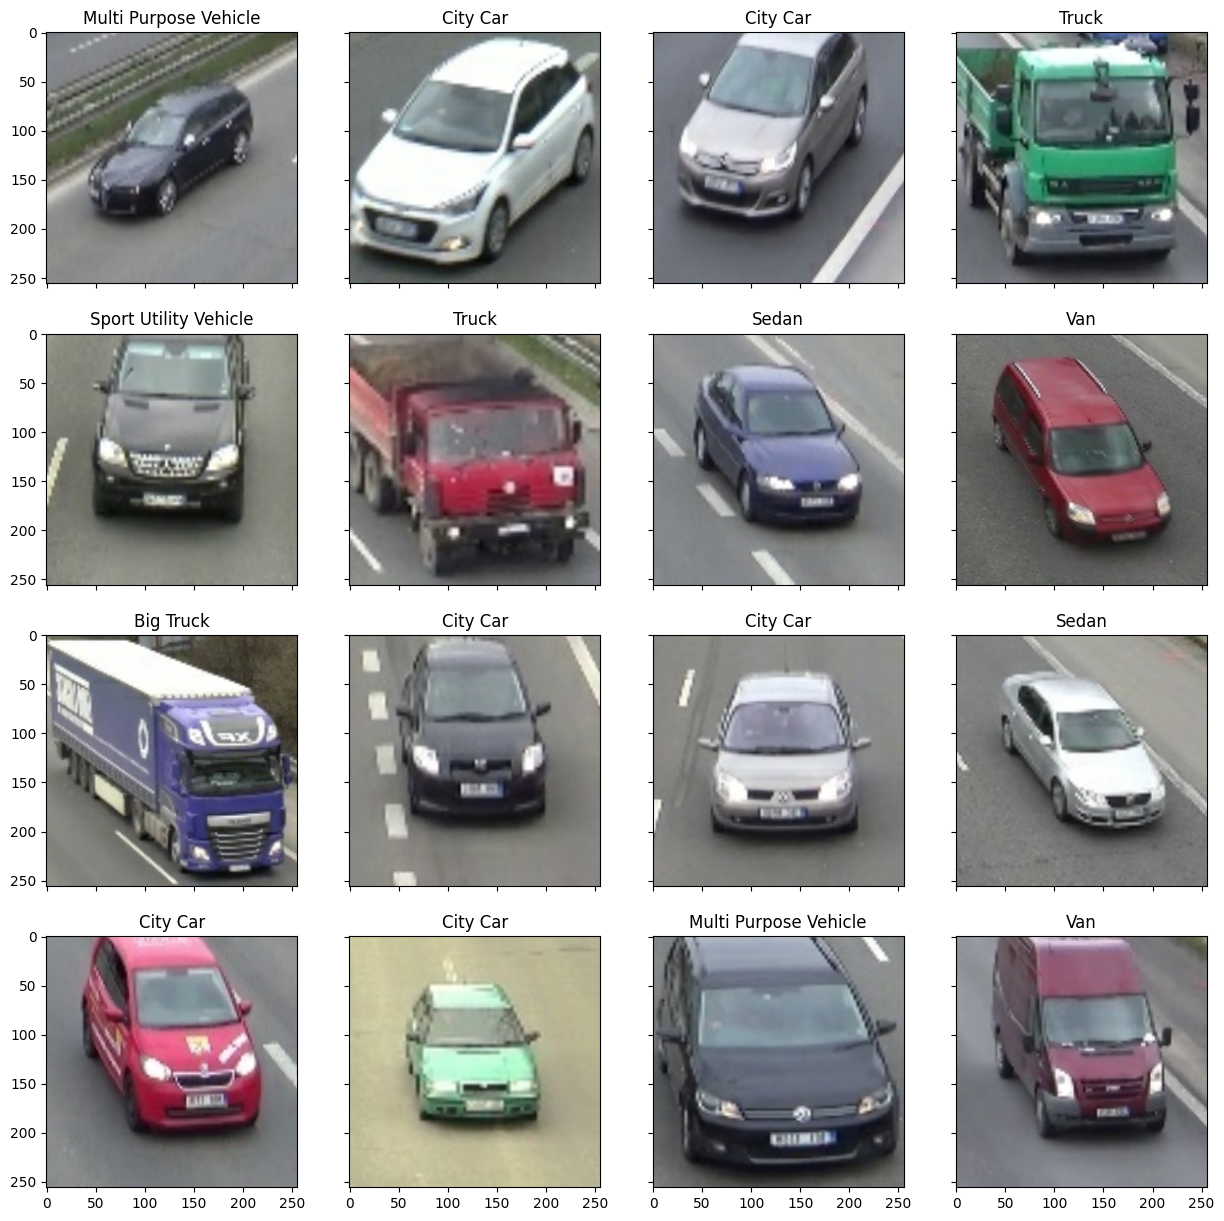

In [ ]:
nb = 4
fig, ax = plt.subplots(nb, nb, sharex=True, sharey=True, figsize=(15,15))
 
for images, labels in train_ds.take(1):
    for i in range(nb):
        for j in range(nb):
            ax[i][j].imshow(images[i*nb+j].numpy().astype("uint8"))
            ax[i][j].set_title(train_ds.class_names[labels[i*nb+j]])
plt.show()

## 2.4 Conception des modèle

### 2.4.1 Model 1: Convolutional Neural Network

Le code fourni définit une architecture de réseau neuronal convolutif (CNN) avec trois blocs de couches convolutives et de regroupement maximum, suivis de couches denses pour la classification. Le modèle prend des images RVB 256x256, applique des opérations convolutives pour extraire des entités, effectue une mise en commun pour réduire les dimensions spatiales, puis fait passer les cartes d'entités aplaties à travers des couches entièrement connectées pour la classification. Le modèle est compilé avec l'optimiseur Adam, la perte d'entropie croisée catégorique clairsemée et la précision comme métrique d'évaluation.

Le modèle prend en 256x256 images RVB et génère des probabilités pour chacune des 7 classes.

Enfin, la fonction model.summary() est utilisée pour afficher un résumé de l'architecture du modèle, y compris le nombre de paramètres dans chaque couche.

In [ ]:
# Define the CNN architecture
model = Sequential()

# Block 1
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

# Block 2
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

# Block 3
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

# Dense layers
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(7, activation='sigmoid'))
model.compile('adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print a summary of the model architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

Mettre en place un arrêt précoce du processus d'apprentissage du modèle, le critère d'arrêt précoce étant la perte de validation. Le rappel `EarlyStopping` surveille la perte de validation et arrête l'entraînement si la perte ne s'améliore pas pendant un certain nombre d'époques définies par le paramètre de `patience` (dans ce cas, 3). L'option `restore_best_weights=True` garantit que les pondérations du modèle sont restaurées aux pondérations les plus performantes observées pendant l'entraînement.

La fonction `model.fit()` est ensuite appelée pour former le modèle à l'aide de l'ensemble de données d'apprentissage (`train_ds`) et le valider à l'aide de l'ensemble de données de validation (`val_ds`). La formation est effectuée pendant 20 époques et le paramètre de rappels est défini pour inclure le rappel `early_stop` pour un arrêt anticipé. L'historique de formation est stocké dans la variable d'historique, qui peut être utilisée pour une analyse plus approfondie et une visualisation du processus de formation.

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(train_ds, validation_data=val_ds, epochs=20, callbacks=[early_stop])

Epoch 1/20
392/392 [==============================] - 25s 63ms/step - loss: 0.9240 - accuracy: 0.6552 - val_loss: 0.9857 - val_accuracy: 0.6424
Epoch 2/20
392/392 [==============================] - 22s 55ms/step - loss: 0.4282 - accuracy: 0.8440 - val_loss: 0.9354 - val_accuracy: 0.6957
Epoch 3/20
392/392 [==============================] - 26s 67ms/step - loss: 0.2142 - accuracy: 0.9296 - val_loss: 1.2635 - val_accuracy: 0.7105
Epoch 4/20
392/392 [==============================] - 23s 57ms/step - loss: 0.1339 - accuracy: 0.9569 - val_loss: 1.3260 - val_accuracy: 0.7200
Epoch 5/20
392/392 [==============================] - 24s 60ms/step - loss: 0.0987 - accuracy: 0.9715 - val_loss: 1.4535 - val_accuracy: 0.6967


Deux sous-graphes pour visualiser la précision d'apprentissage et de validation ainsi que la perte d'apprentissage et de validation au cours des époques.

In [ ]:
# plot the learning curves
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(history.history['accuracy'], label='training accuracy')
ax.plot(history.history['val_accuracy'], label='validation accuracy')
ax.set_title('Model Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend()
plt.show()

fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(history.history['loss'], label='training loss')
ax.plot(history.history['val_loss'], label='validation loss')
ax.set_title('Model Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()
plt.show()

le modèle formé pour faire des prédictions sur l'ensemble de données de validation (`val_ds`). La fonction `model.predict()` est appelée, en passant l'ensemble de données de validation comme entrée, et les prédictions sont stockées dans la variable `predictions`. Cela permet d'obtenir les probabilités prédites ou les étiquettes de classe pour chaque instance de l'ensemble de données de validation.

In [ ]:
predictions = model.predict(val_ds)

98/98 [==============================] - 3s 34ms/step


Affecter les étiquettes de classe prédites à la variable `y_pred`. Il utilise la fonction `np.argmax()` pour trouver l'indice de la probabilité la plus élevée dans chaque tableau de prédiction le long de l'axe spécifié (dans ce cas, l'axe 1). En prenant l'argmax le long de l'axe 1, le code identifie l'étiquette de classe prédite avec la probabilité la plus élevée pour chaque instance dans l'ensemble de données de validation. La variable `y_pred` qui en résulte contient les étiquettes de classe prédites pour l'ensemble de données de validation.

In [ ]:
y_pred = np.argmax(predictions, axis=1)

La variable `y_true`, qui représente les véritables étiquettes de classe de l'ensemble de données de validation. Pour ce faire, il itère dans l'ensemble de données de validation `val_ds` et extrait les véritables étiquettes de classe (`y`) pour chaque lot. Les lots sont ensuite concaténés le long de l'axe 0 à l'aide de `np.concatenate()`, ce qui donne un tableau unique contenant les vraies étiquettes de classe pour toutes les instances de l'ensemble de données de validation. La variable `y_true` qui en résulte contient les véritables étiquettes de classe correspondant aux instances de l'ensemble de données de validation.

In [ ]:
y_true = np.concatenate([y for x, y in val_ds], axis=0)

Génèrer un rapport de classification basé sur les vraies étiquettes de classe (`y_true`) et les étiquettes de classe prédites (`y_pred`). La fonction `classification_report()` de scikit-learn est utilisée à cette fin. Elle calcule diverses mesures d'évaluation telles que la précision, le rappel, le score F1 et le soutien pour chaque classe de l'ensemble de données de validation. Le paramètre `target_names` est défini sur `val_ds.class_names` afin de fournir des étiquettes significatives pour chaque classe dans le rapport. Enfin, le rapport de classification est imprimé à l'aide de print(). Ce rapport fournit un résumé détaillé des performances du modèle sur l'ensemble de données de validation, y compris les métriques pour chaque classe et les mesures de performances globales.

In [ ]:
# Compute the confusion matrix, accuracy, precision, recall, and F1 score
report = classification_report(y_true, y_pred, target_names=val_ds.class_names)
print('Classification Report:\n', report)

Classification Report:
                        precision    recall  f1-score   support

            Big Truck       0.67      0.85      0.75       119
             City Car       0.68      0.71      0.70       950
Multi Purpose Vehicle       0.65      0.64      0.65       539
                Sedan       0.65      0.62      0.63       510
Sport Utility Vehicle       0.67      0.60      0.63       373
                Truck       0.87      0.75      0.80       219
                  Van       0.79      0.83      0.81       419

             accuracy                           0.70      3129
            macro avg       0.71      0.71      0.71      3129
         weighted avg       0.70      0.70      0.69      3129



La fonction `model.save()` est utilisée pour enregistrer l'ensemble du modèle, y compris l'architecture, l'optimiseur et les poids appris, au format Hierarchical Data Format (HDF5). Ce modèle sauvegardé peut être chargé ultérieurement et utilisé pour l'inférence ou l'entraînement ultérieur.

In [ ]:
model.save("vehicle_classification_v1.h5")

Connexion au service de stockage en nuage Mega à l'aide des identifiants de connexion fournis. Il recherche ensuite un dossier nommé "text_classification" à l'aide de la méthode mega.find(). Une fois le dossier trouvé, il télécharge le fichier "vehicle_classification_v1.h5" dans ce dossier à l'aide de la méthode mega.upload(). Cela permet de télécharger le fichier du modèle formé et de le stocker dans le dossier spécifié sur Mega.

In [ ]:
mega = Mega()
mega._login_user('models@tonestudio.fr','models@tonestudio.fr')

folder = mega.find('text_classification')
mega.upload('vehicle_classification_v1.h5', folder[0])

{'f': [{'h': 'wBkR2BaS',
   't': 0,
   'a': 'JVne3SuEdWOt8PVMPdWW4qqK-xvMa6iXWPir3imS-NUaDMk1r8XluTMyZbBicm7H',
   'k': '0KUDtk3uCr4:lw0GzyYDWNh9gg7ieg_wphadCeJYZIljUyIZEKUhsdI',
   'p': '5M1T0RIa',
   'ts': 1684181615,
   'u': '0KUDtk3uCr4',
   's': 44430232}]}

### 2.4.2 Model 2: Convolutional Neural Network with Dropout

In [ ]:
# Define the CNN architecture
model = Sequential()

# Block 1
model.add(Conv2D(32, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(Dropout(0.4))
model.add(MaxPooling2D())

# Block 2
model.add(Conv2D(64, (2,2), 1, activation='relu'))
model.add(Dropout(0.4))
model.add(MaxPooling2D())

# Block 3
model.add(Conv2D(64, (2,2), 1, activation='relu'))
model.add(Dropout(0.2))

# Dense layers
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(7, activation='sigmoid'))
model.compile('adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print a summary of the model architecture
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 dropout (Dropout)           (None, 254, 254, 32)      0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 126, 126, 64)      8256      
                                                                 
 dropout_1 (Dropout)         (None, 126, 126, 64)      0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 63, 63, 64)       0         
 2D)                                                  

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(train_ds, validation_data=val_ds, epochs=20, callbacks=[early_stop])

Epoch 1/20
392/392 [==============================] - 60s 142ms/step - loss: 207.9121 - accuracy: 0.3050 - val_loss: 1.7204 - val_accuracy: 0.3640
Epoch 2/20
392/392 [==============================] - 57s 144ms/step - loss: 1.3929 - accuracy: 0.4560 - val_loss: 1.4668 - val_accuracy: 0.4596
Epoch 3/20
392/392 [==============================] - 57s 144ms/step - loss: 1.0348 - accuracy: 0.6035 - val_loss: 1.2551 - val_accuracy: 0.5299
Epoch 4/20
392/392 [==============================] - 56s 143ms/step - loss: 0.7226 - accuracy: 0.7314 - val_loss: 1.1568 - val_accuracy: 0.5941
Epoch 5/20
392/392 [==============================] - 55s 139ms/step - loss: 0.4741 - accuracy: 0.8352 - val_loss: 1.1383 - val_accuracy: 0.5900
Epoch 6/20
392/392 [==============================] - 56s 141ms/step - loss: 0.3487 - accuracy: 0.8816 - val_loss: 1.1054 - val_accuracy: 0.6222
Epoch 7/20
392/392 [==============================] - 58s 146ms/step - loss: 0.2515 - accuracy: 0.9207 - val_loss: 1.0712 - val_

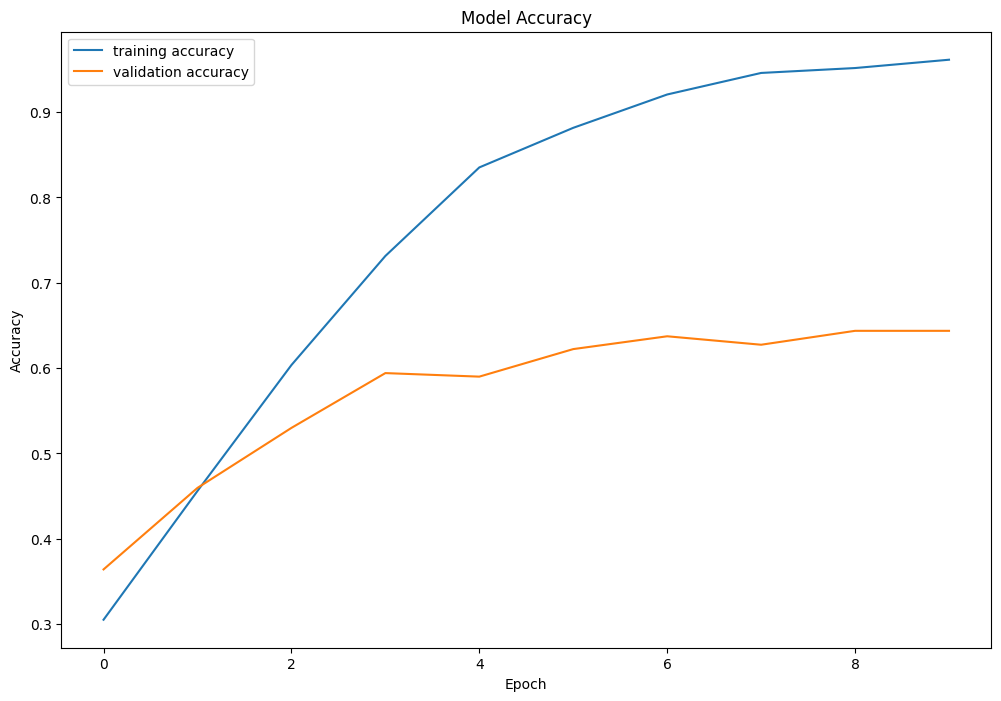

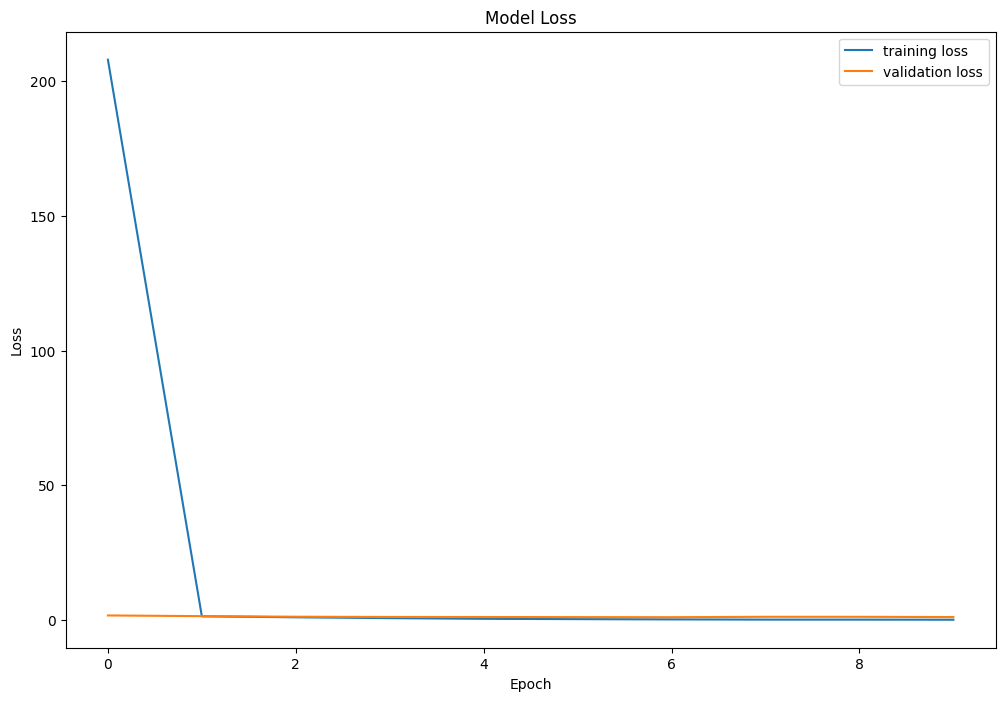

In [ ]:
# plot the learning curves
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(history.history['accuracy'], label='training accuracy')
ax.plot(history.history['val_accuracy'], label='validation accuracy')
ax.set_title('Model Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend()
plt.show()

fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(history.history['loss'], label='training loss')
ax.plot(history.history['val_loss'], label='validation loss')
ax.set_title('Model Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()
plt.show()

In [ ]:
predictions = model.predict(val_ds)

98/98 [==============================] - 4s 40ms/step


In [ ]:
y_pred = np.argmax(predictions, axis=1)

In [ ]:
y_true = np.concatenate([y for x, y in val_ds], axis=0)

In [ ]:
# Compute the confusion matrix, accuracy, precision, recall, and F1 score
report = classification_report(y_true, y_pred, target_names=val_ds.class_names)
print('Classification Report:\n', report)

Classification Report:
                        precision    recall  f1-score   support

            Big Truck       0.70      0.74      0.72       119
             City Car       0.62      0.73      0.67       950
Multi Purpose Vehicle       0.56      0.54      0.55       539
                Sedan       0.52      0.58      0.55       510
Sport Utility Vehicle       0.68      0.46      0.55       373
                Truck       0.82      0.74      0.78       219
                  Van       0.82      0.70      0.75       419

             accuracy                           0.64      3129
            macro avg       0.68      0.64      0.65      3129
         weighted avg       0.65      0.64      0.64      3129



In [ ]:
model.save("vehicle_classification_v2.h5")

In [ ]:
mega = Mega()
mega._login_user('models@tonestudio.fr','models@tonestudio.fr')

folder = mega.find('text_classification')
mega.upload('vehicle_classification_v2.h5', folder[0])

{'f': [{'h': '8FNE2JBQ',
   't': 0,
   'a': 'qGk4hZncds2VURXtHBulMY465XcKMDZN46wDaQfDSZnF4iQHtnpw5LgAVPbBmeKt',
   'k': '0KUDtk3uCr4:gTj2ELKoO62kz3yuKiuKfCCwBTbMhSgNLHiJnVo0DT0',
   'p': '5M1T0RIa',
   'ts': 1684181572,
   'u': '0KUDtk3uCr4',
   's': 756147048}]}

### 2.4.3 Model 3: Convolutional Neural Network with Multiple Convolutional Blocks

In [ ]:
# Define the input shape of the images
input_shape = (256, 256, 3)

# Define the number of classes in the dataset
num_classes = 7

# Define the CNN architecture
model = Sequential()

# Block 1
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D((2, 2)))

# Block 2
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Block 3
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Dense layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.compile('adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print a summary of the model architecture
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 30, 30, 128)     

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(train_ds, validation_data=val_ds, epochs=20, callbacks=[early_stop])

Epoch 1/20
392/392 [==============================] - 36s 85ms/step - loss: 6.6521 - accuracy: 0.2970 - val_loss: 1.6556 - val_accuracy: 0.3653
Epoch 2/20
392/392 [==============================] - 32s 81ms/step - loss: 1.6722 - accuracy: 0.3469 - val_loss: 1.5457 - val_accuracy: 0.3806
Epoch 3/20
392/392 [==============================] - 33s 84ms/step - loss: 1.4968 - accuracy: 0.4122 - val_loss: 1.6359 - val_accuracy: 0.3918
Epoch 4/20
392/392 [==============================] - 32s 82ms/step - loss: 1.3773 - accuracy: 0.4545 - val_loss: 1.3564 - val_accuracy: 0.4685
Epoch 5/20
392/392 [==============================] - 31s 78ms/step - loss: 1.2162 - accuracy: 0.5221 - val_loss: 1.2286 - val_accuracy: 0.5292
Epoch 6/20
392/392 [==============================] - 30s 76ms/step - loss: 1.0483 - accuracy: 0.5956 - val_loss: 1.1781 - val_accuracy: 0.5532
Epoch 7/20
392/392 [==============================] - 32s 81ms/step - loss: 0.9260 - accuracy: 0.6415 - val_loss: 1.1370 - val_accuracy:

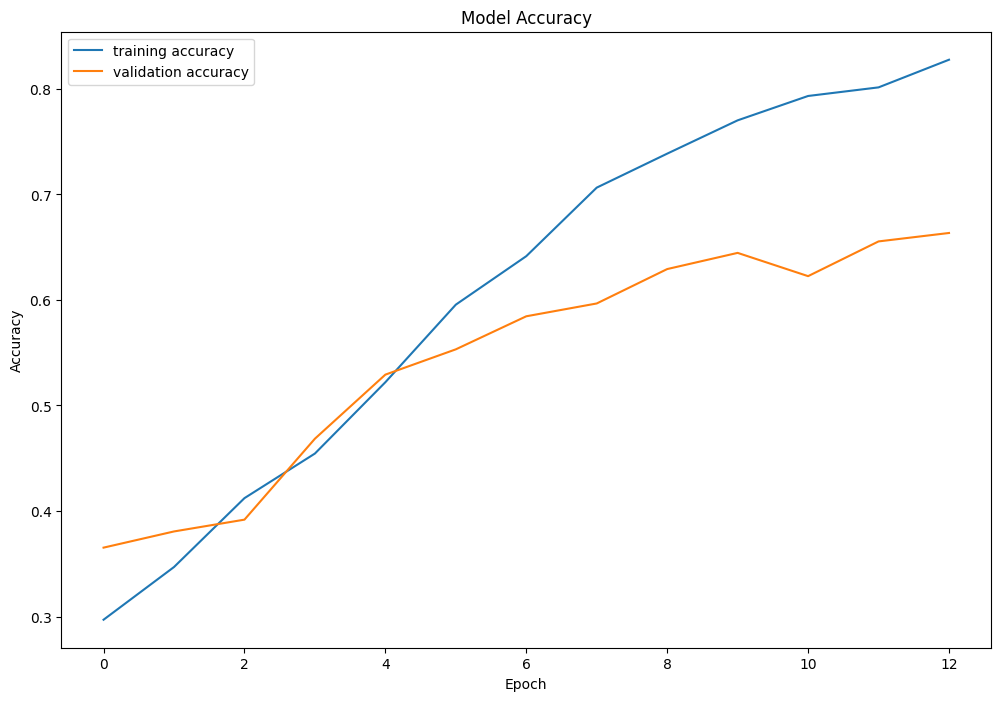

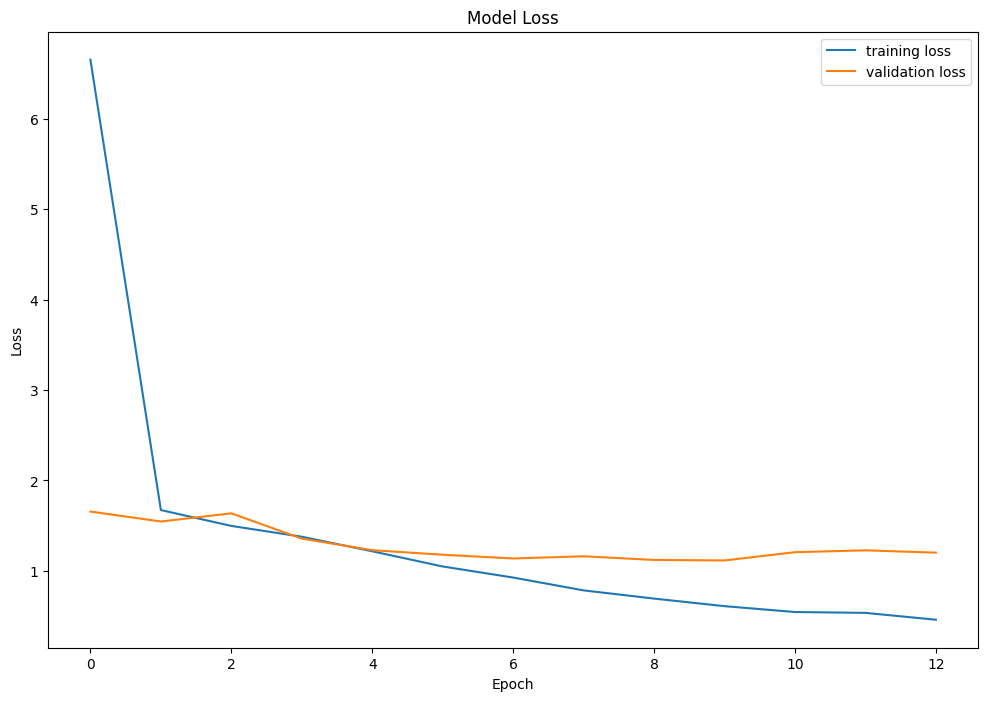

In [ ]:
# plot the learning curves
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(history.history['accuracy'], label='training accuracy')
ax.plot(history.history['val_accuracy'], label='validation accuracy')
ax.set_title('Model Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend()
plt.show()

fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(history.history['loss'], label='training loss')
ax.plot(history.history['val_loss'], label='validation loss')
ax.set_title('Model Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()
plt.show()

In [ ]:
predictions = model.predict(val_ds)

98/98 [==============================] - 4s 42ms/step


In [ ]:
y_pred = np.argmax(predictions, axis=1)

In [ ]:
y_true = np.concatenate([y for x, y in val_ds], axis=0)

In [ ]:
# Compute the confusion matrix, accuracy, precision, recall, and F1 score
report = classification_report(y_true, y_pred, target_names=val_ds.class_names)
print('Classification Report:\n', report)

Classification Report:
                        precision    recall  f1-score   support

            Big Truck       0.80      0.62      0.70       119
             City Car       0.62      0.73      0.67       950
Multi Purpose Vehicle       0.62      0.53      0.57       539
                Sedan       0.55      0.54      0.54       510
Sport Utility Vehicle       0.69      0.57      0.63       373
                Truck       0.81      0.76      0.78       219
                  Van       0.70      0.74      0.72       419

             accuracy                           0.64      3129
            macro avg       0.68      0.64      0.66      3129
         weighted avg       0.65      0.64      0.64      3129



In [ ]:
model.save("vehicle_classification_v3.h5")

In [ ]:
mega = Mega()
mega._login_user('models@tonestudio.fr','models@tonestudio.fr')

folder = mega.find('text_classification')
mega.upload('vehicle_classification_v3.h5', folder[0])

{'f': [{'h': 'wEtVFA7Q',
   't': 0,
   'a': 'NYEfApUXZL643aseaig3aHVGHKAXwuquLhiFTmavKD_7oYQZ8U9S7KbknSHDFyzi',
   'k': '0KUDtk3uCr4:-PI-nlckQAFq8YxLoICXB_RsnJlCsiu0O27eywGd9bo',
   'p': '5M1T0RIa',
   'ts': 1684182413,
   'u': '0KUDtk3uCr4',
   's': 178132320}]}

### 2.4.4 Model 4: Convolutional Neural Network with Regularization

In [ ]:
# Define the input shape of the images
input_shape = (256, 256, 3)

# Define the number of classes in the dataset
num_classes = 7

# Define the CNN architecture
model = Sequential()

# Block 1
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, 
                 kernel_regularizer=regularizers.l2(0.001), 
                 kernel_initializer=initializers.he_normal(),
                 kernel_constraint=constraints.max_norm(3)))
model.add(MaxPooling2D((2, 2)))

# Block 2
model.add(Conv2D(64, (3, 3), activation='relu', 
                 kernel_regularizer=regularizers.l2(0.001), 
                 kernel_initializer=initializers.he_normal(),
                 kernel_constraint=constraints.max_norm(3)))
model.add(MaxPooling2D((2, 2)))

# Block 3
model.add(Conv2D(128, (3, 3), activation='relu', 
                 kernel_regularizer=regularizers.l2(0.001), 
                 kernel_initializer=initializers.he_normal(),
                 kernel_constraint=constraints.max_norm(3)))
model.add(MaxPooling2D((2, 2)))

# Dense layers
model.add(Flatten())
model.add(Dense(128, activation='relu', 
                kernel_regularizer=regularizers.l2(0.001),
                kernel_initializer=initializers.he_normal(),
                kernel_constraint=constraints.max_norm(3)))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.compile('adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print a summary of the model architecture
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 30, 30, 128)     

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(train_ds, validation_data=val_ds, epochs=20, callbacks=[early_stop])

Epoch 1/20
392/392 [==============================] - 34s 78ms/step - loss: 99.0222 - accuracy: 0.2801 - val_loss: 2.4164 - val_accuracy: 0.3132
Epoch 2/20
392/392 [==============================] - 34s 86ms/step - loss: 2.3876 - accuracy: 0.3292 - val_loss: 2.3487 - val_accuracy: 0.3353
Epoch 3/20
392/392 [==============================] - 32s 81ms/step - loss: 2.3096 - accuracy: 0.3648 - val_loss: 2.3314 - val_accuracy: 0.3886
Epoch 4/20
392/392 [==============================] - 34s 87ms/step - loss: 2.2583 - accuracy: 0.4029 - val_loss: 2.3103 - val_accuracy: 0.3810
Epoch 5/20
392/392 [==============================] - 33s 83ms/step - loss: 2.2449 - accuracy: 0.3989 - val_loss: 2.3142 - val_accuracy: 0.3691
Epoch 6/20
392/392 [==============================] - 33s 82ms/step - loss: 2.2718 - accuracy: 0.3940 - val_loss: 2.3435 - val_accuracy: 0.3624
Epoch 7/20
392/392 [==============================] - 33s 83ms/step - loss: 2.1539 - accuracy: 0.4189 - val_loss: 2.2573 - val_accuracy

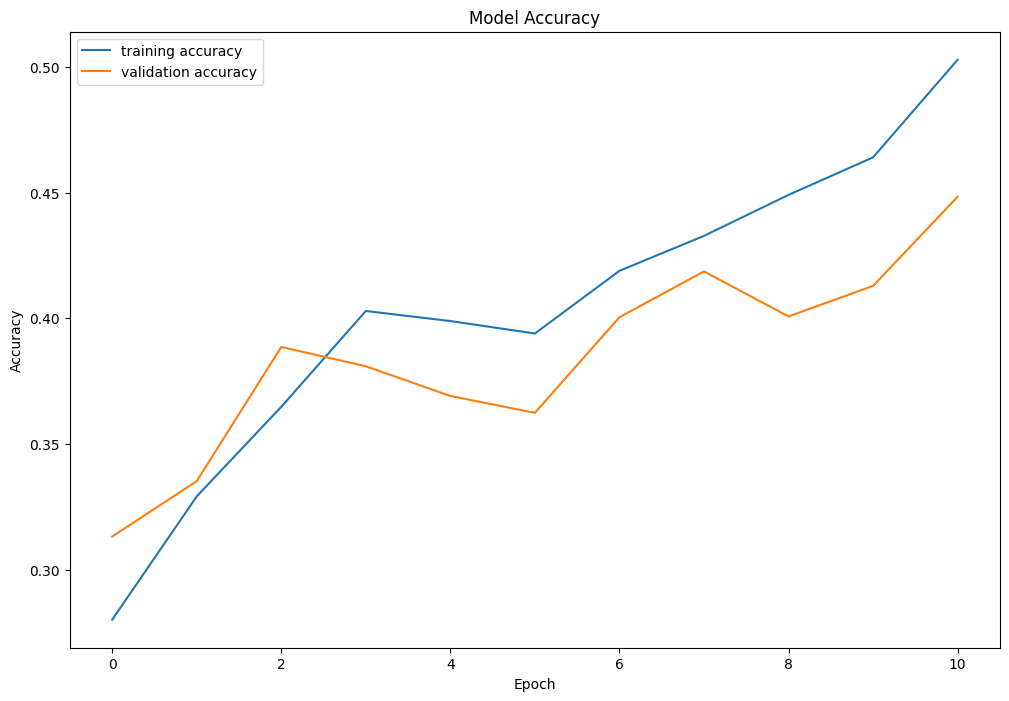

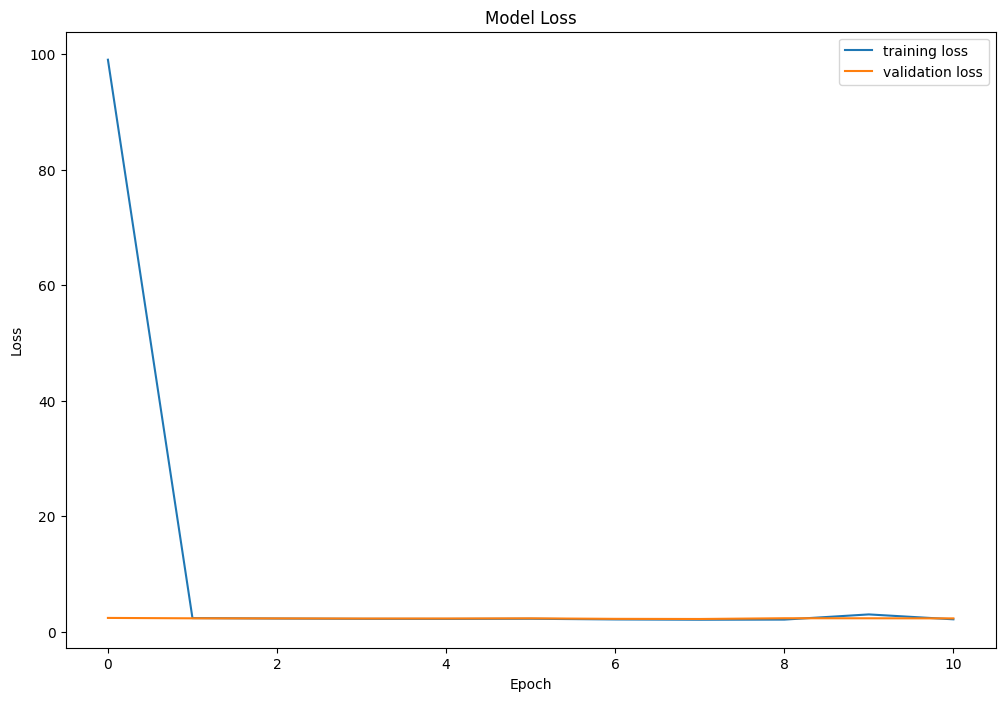

In [ ]:
# plot the learning curves
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(history.history['accuracy'], label='training accuracy')
ax.plot(history.history['val_accuracy'], label='validation accuracy')
ax.set_title('Model Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend()
plt.show()

fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(history.history['loss'], label='training loss')
ax.plot(history.history['val_loss'], label='validation loss')
ax.set_title('Model Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()
plt.show()

In [ ]:
predictions = model.predict(val_ds)

98/98 [==============================] - 6s 58ms/step


In [ ]:
y_pred = np.argmax(predictions, axis=1)

In [ ]:
y_true = np.concatenate([y for x, y in val_ds], axis=0)

In [ ]:
# Compute the confusion matrix, accuracy, precision, recall, and F1 score
report = classification_report(y_true, y_pred, target_names=val_ds.class_names)
print('Classification Report:\n', report)

Classification Report:
                        precision    recall  f1-score   support

            Big Truck       0.56      0.55      0.56       119
             City Car       0.41      0.75      0.53       950
Multi Purpose Vehicle       0.36      0.21      0.26       539
                Sedan       0.26      0.16      0.20       510
Sport Utility Vehicle       0.44      0.21      0.28       373
                Truck       0.58      0.52      0.55       219
                  Van       0.52      0.35      0.42       419

             accuracy                           0.42      3129
            macro avg       0.45      0.39      0.40      3129
         weighted avg       0.41      0.42      0.39      3129



In [ ]:
model.save("vehicle_classification_v4.h5")

In [ ]:
mega = Mega()
mega._login_user('models@tonestudio.fr','models@tonestudio.fr')

folder = mega.find('text_classification')
mega.upload('vehicle_classification_v4.h5', folder[0])

### 2.4.5 CNN EfficientNet

EfficientNetB0 est un modèle de réseau neuronal convolutionnel pré-entraîné qui appartient à la famille des modèles EfficientNet. Il est spécialement conçu pour atteindre une grande précision tout en étant efficace sur le plan informatique en termes de nombre de paramètres et d'opérations. EfficientNetB0 sert d'extracteur de caractéristiques qui a été entraîné sur un ensemble de données à grande échelle, tel qu'ImageNet, pour apprendre des représentations d'images riches et discriminantes.

En utilisant EfficientNetB0 comme modèle de base, vous pouvez bénéficier de ses puissantes capacités d'extraction de caractéristiques. Vous pouvez l'utiliser comme un extracteur de caractéristiques fixe, où les poids pré-entraînés sont gelés, ou l'affiner en formant des couches supplémentaires au-dessus du modèle pré-entraîné. Cela vous permet d'exploiter les représentations apprises et de les adapter à votre tâche spécifique de classification d'images.

L'utilisation de modèles pré-entraînés comme EfficientNetB0 permet d'économiser beaucoup de temps et de ressources informatiques par rapport à l'entraînement d'un CNN à partir de zéro. Ces modèles ont été entraînés sur de grandes quantités de données, ce qui leur permet de capturer des caractéristiques et des modèles généralisables présents dans les images.

* `weights=None` indique qu'aucun poids pré-entraîné n'est chargé dans le modèle, de sorte que le modèle sera initialisé avec des poids aléatoires.
* `include_top=True` inclut la couche supérieure entièrement connectée du modèle, qui est responsable de la classification finale.

In [ ]:
# Set the input shape
input_shape = (256, 256, 3)

# Create the EfficientNet model
model = EfficientNetB0(input_shape=input_shape, weights=None, include_top=True, classes=len(train_ds.class_names))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 256, 256, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 257, 257, 3)  0           ['normalization[0][0

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(train_ds, validation_data=val_ds, epochs=20, callbacks=[early_stop])

Epoch 1/20
392/392 [==============================] - 211s 361ms/step - loss: 2.1167 - accuracy: 0.3010 - val_loss: 2.9107 - val_accuracy: 0.3036
Epoch 2/20
392/392 [==============================] - 140s 356ms/step - loss: 1.4502 - accuracy: 0.4224 - val_loss: 1.3137 - val_accuracy: 0.4551
Epoch 3/20
392/392 [==============================] - 139s 354ms/step - loss: 1.1317 - accuracy: 0.5360 - val_loss: 1.2548 - val_accuracy: 0.5113
Epoch 4/20
392/392 [==============================] - 139s 354ms/step - loss: 0.9150 - accuracy: 0.6292 - val_loss: 1.0227 - val_accuracy: 0.6123
Epoch 5/20
392/392 [==============================] - 139s 354ms/step - loss: 0.7313 - accuracy: 0.7096 - val_loss: 0.8838 - val_accuracy: 0.6737
Epoch 6/20
392/392 [==============================] - 139s 355ms/step - loss: 0.5846 - accuracy: 0.7769 - val_loss: 1.0713 - val_accuracy: 0.6462
Epoch 7/20
392/392 [==============================] - 139s 355ms/step - loss: 0.4650 - accuracy: 0.8221 - val_loss: 0.8376 -

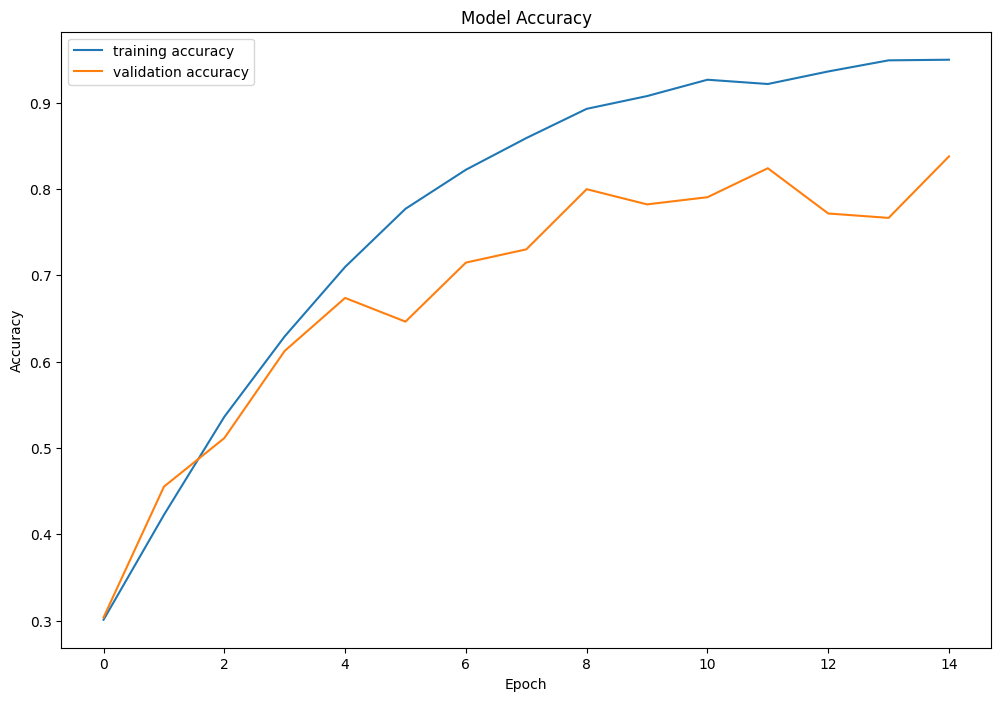

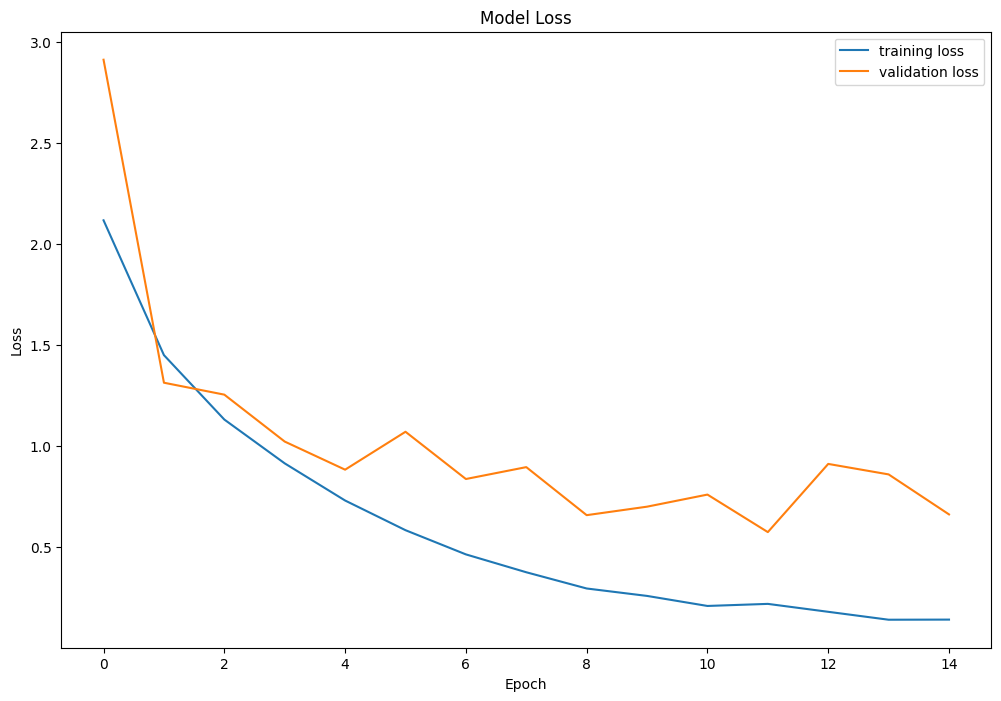

In [ ]:
# plot the learning curves
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(history.history['accuracy'], label='training accuracy')
ax.plot(history.history['val_accuracy'], label='validation accuracy')
ax.set_title('Model Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend()
plt.show()

fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(history.history['loss'], label='training loss')
ax.plot(history.history['val_loss'], label='validation loss')
ax.set_title('Model Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()
plt.show()

In [ ]:
predictions = model.predict(val_ds)

98/98 [==============================] - 9s 75ms/step


In [ ]:
y_pred = np.argmax(predictions, axis=1)

In [ ]:
y_true = np.concatenate([y for x, y in val_ds], axis=0)

In [ ]:
# Compute the confusion matrix, accuracy, precision, recall, and F1 score
report = classification_report(y_true, y_pred, target_names=val_ds.class_names)
print('Classification Report:\n', report)

Classification Report:
                        precision    recall  f1-score   support

            Big Truck       0.82      0.89      0.85       119
             City Car       0.85      0.76      0.80       950
Multi Purpose Vehicle       0.74      0.73      0.73       539
                Sedan       0.73      0.89      0.80       510
Sport Utility Vehicle       0.84      0.80      0.82       373
                Truck       0.94      0.88      0.91       219
                  Van       0.94      0.98      0.96       419

             accuracy                           0.82      3129
            macro avg       0.84      0.85      0.84      3129
         weighted avg       0.83      0.82      0.82      3129



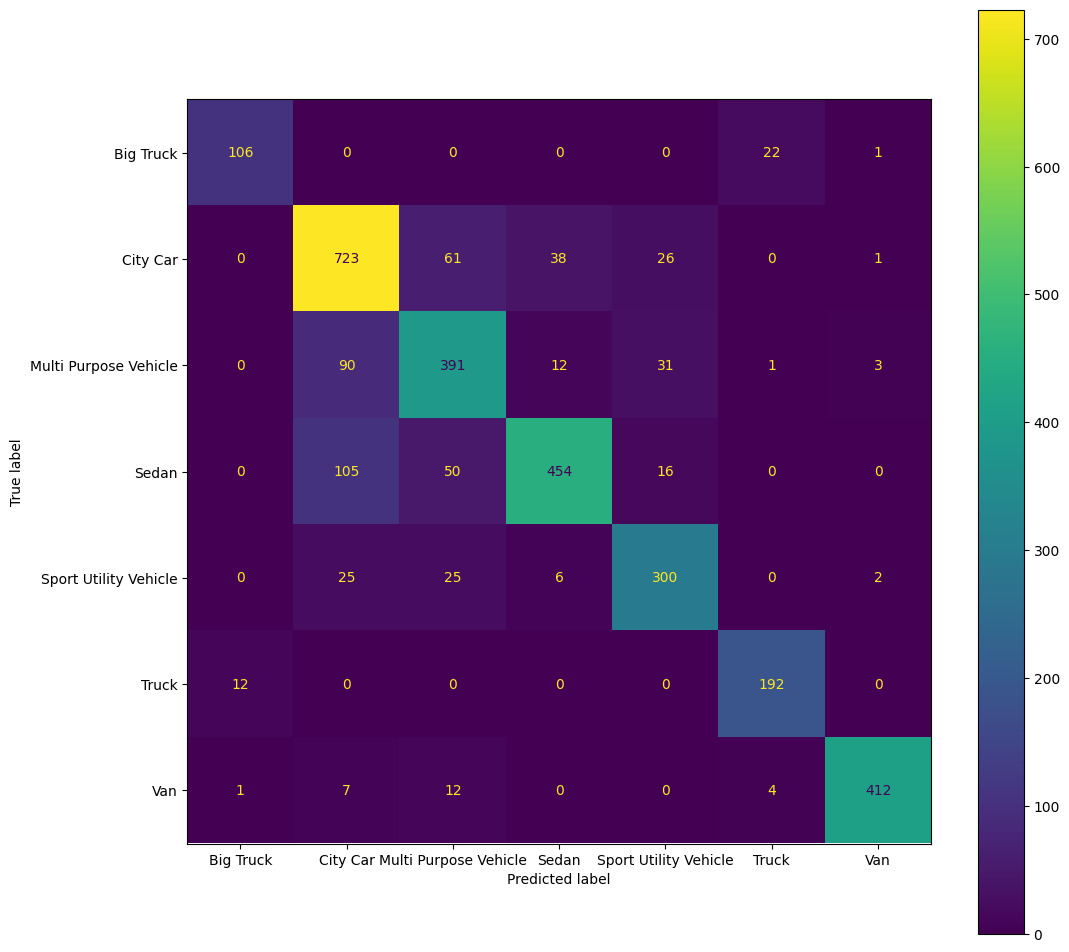

In [ ]:
fig, ax = plt.subplots(figsize=(12, 12))
confusion_matrix = confusion_matrix(y_pred, y_true)
ConfusionMatrixDisplay(confusion_matrix, display_labels = val_ds.class_names).plot(ax=ax)

In [ ]:
model.save("vehicle_classification_EfficientNet.h5")

In [ ]:
mega = Mega()
mega._login_user('models@tonestudio.fr','models@tonestudio.fr')

folder = mega.find('image_classification')
mega.upload('vehicle_classification_EfficientNet.h5', folder[0])

{'f': [{'h': 'MVkFjSZT',
   't': 0,
   'a': '86jNhFmVnZHi6-Tfe7hqkrPKZ03VTvJwAtAO3MT5bxKT1klrM_rzOi3G5_N5VyBOwCiUqQmkHGHRJBBPwSBalg',
   'k': '0KUDtk3uCr4:FNucw4tsS0XEadGcGOf8vnMtrbsGhguasb0IvES1nAU',
   'p': 'tAsFXawK',
   'ts': 1684227804,
   'u': '0KUDtk3uCr4',
   's': 49480640}]}

## 2.6 Comparation des modele

| Model | Accuracy | precision | recall | f1-score |
| :- | -: | -: | -: | -: |
| CNN | 70 | 71 | 71 | 71
| CNN with dropout | 64 | 68 | 64| 65
| CNN Multiple Convolutional Blocks | 64 | 68 | 64 | 66
| Convolutional Neural Network with Regularization | 42 | 45 | 39 | 40
| EfficientNet | 82 | 84 | 85 | 84

## 2.7 Méthode de prédiction

### 2.7.1 Méthode de prédiction avec le chemin en entrée.

Pour utiliser que la méthode de prédiction, suivre les étapes suivants :

1. Téléchargez et installez les packages et leurs dépendances. (bloc 2.1)
2. Importation des bibliothèques et modules nécessaires. (bloc 2.2)
3. Exécuter la cellule contient la login MEGA une fois que l'identifiant est remplie. (bloc 2.3)

Si vous n'ête pas conserné par les personnes qui ont eu l'identifiant partager, télecherger les models + tokenizer manuellement et importer sur colab.

  - CNN : https://mega.nz/file/EYNHUZ7A#qZvYARtKcb05LJhsQW1bfoDcK0oJhUbgU_NsVFG3RUQ
  - CNN with dropout : https://mega.nz/file/EYNHUZ7A#qZvYARtKcb05LJhsQW1bfoDcK0oJhUbgU_NsVFG3RUQ
  - CNN Multiple Convolutional Blocks :  https://mega.nz/file/EYNHUZ7A#qZvYARtKcb05LJhsQW1bfoDcK0oJhUbgU_NsVFG3RUQ
  - CNN with Regularization : https://mega.nz/file/8VtjXSyA#c7WOoBiuK0ml_TJhCX95aLvn--anlnS2NNpPyKxzDig
  - EfficientNet : https://mega.nz/file/0FkglCjb#l_MXYl2iBJR92s-NWIooi5o9r5va-4ioCrjC5Nvumt8

In [9]:
def custom_predict(model_name, image_path):
  model_names = {
      'cnn_base' : 'vehicle_classification_v1.h5',
      'cnn_dropout' : 'vehicle_classification_v2.h5',
      'cnn_filter_size' : 'vehicle_classification_v3.h5',
      'cnn_l2' : 'vehicle_classification_v4.h5',
      'EfficientNet' : 'vehicle_classification_EfficientNet.h5'
  }
  if model_name in model_names.keys():
    if not os.path.isfile(model_names[model_name]):
      print('Downloadeding model...')
      file = mega.find('image_classification/'+model_names[model_name])
      mega.download(file)
      print('Model downloaded.')
    model = load_model(model_names[model_name])
    img = tf.keras.utils.load_img(image_path, target_size=(256, 256))
    x = tf.keras.utils.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])
    classes = model.predict(images)
    predicted_classes = np.argmax(classes, axis=1)
    class_names = ['Big Truck', 'City Car', 'Multi Purpose Vehicle', 'Sedan', 'Sport Utility Vehicle', 'Truck', 'Van']
    predicted_class_name = class_names[predicted_classes[0]]
    predicted_classs_prob = dict(zip(class_names, np.round(classes[0], 3)))
    return {'class' : predicted_class_name, 'probability' : str(predicted_classs_prob[predicted_class_name]*100)+"%"}
  else:
    print('model name not found, possible name are : ', model_names.keys())

In [10]:
model_names = ['cnn_base', 'cnn_dropout', 'cnn_filter_size', 'cnn_l2', 'EfficientNet']

In [12]:
custom_predict(model_names[0], 'dataset/City Car/Image_000578.jpg')

1/1 [==============================] - 0s 171ms/step


{'class': 'City Car', 'probability': '100.0%'}

### 2.6.2 `[EXPERIMENT]` Prédiction avec les images scrapper sur internet.

In [ ]:
search_keyword = "car"

In [ ]:
downloader.download(search_keyword, limit=5,  output_dir='test', adult_filter_off=True, force_replace=False, timeout=60)

[%] Downloading Images to /content/test/car


[!!]Indexing page: 1

[%] Indexed 5 Images on Page 1.


[%] Downloading Image #1 from https://befirstrank.com/wp-content/uploads/2017/10/nissansings-TA.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://images.pexels.com/photos/244206/pexels-photo-244206.jpeg?cs=srgb&amp;dl=lights-car-vehicle-244206.jpg&amp;fm=jpg
[%] File Downloaded !

[%] Downloading Image #3 from http://www.pixelstalk.net/wp-content/uploads/2016/07/Desktop-car-pictures-and-wallpapers.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://3.bp.blogspot.com/-p2TlvJ4yym8/TbpaOXTPXcI/AAAAAAAAAAc/6aCXodifJsk/s1600/2009_dodge_viper_srt10.jpeg
[%] File Downloaded !

[%] Downloading Image #5 from https://www.stugon.com/wp-content/uploads/2013/12/Exotic-Car-Wallpapers-HD-Edition-stugon.com-15.jpg
[%] File Downloaded !



[%] Done. Downloaded 5 images.


In [ ]:
test_t = tf.keras.utils.image_dataset_from_directory('test', shuffle=True,batch_size=BATCH_SIZE,image_size=IMG_SIZE)

Found 5 files belonging to 1 classes.


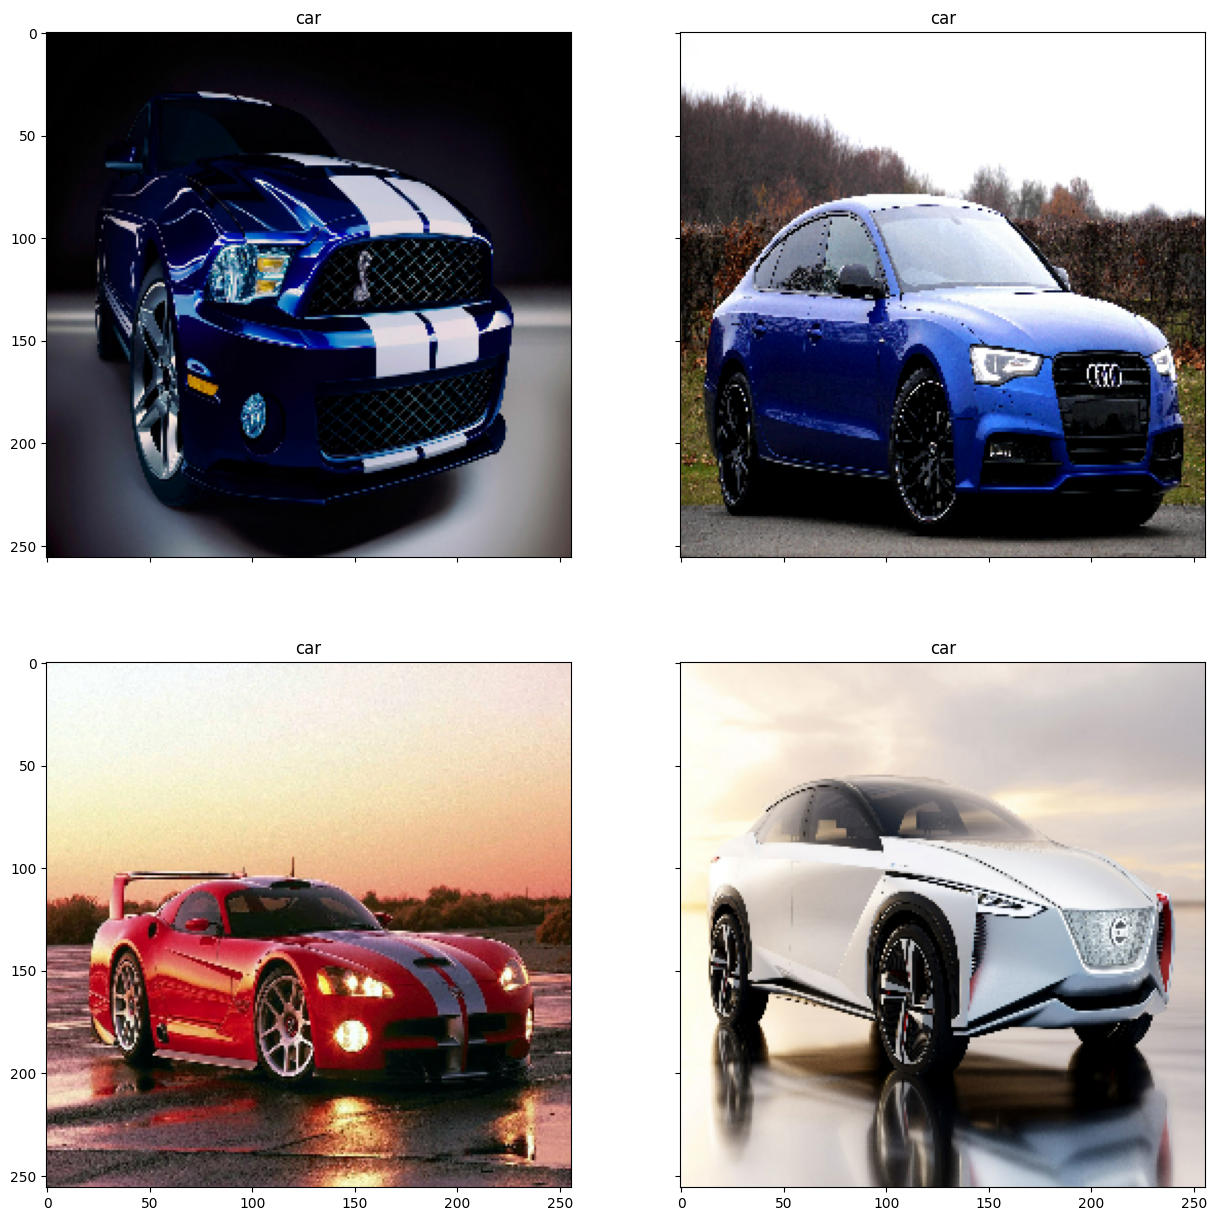

In [ ]:
nb = 2
fig, ax = plt.subplots(nb, nb, sharex=True, sharey=True, figsize=(15,15))
 
for images, labels in test_t.take(1):
    for i in range(nb):
        for j in range(nb):
            ax[i][j].imshow(images[i*nb+j].numpy().astype("uint8"))
            ax[i][j].set_title(test_t.class_names[labels[i*nb+j]])
plt.show()

In [ ]:
model = load_model("vehicle_classification_EfficientNet.h5")

In [ ]:
predictions = model.predict(test_t)

1/1 [==============================] - 3s 3s/step


In [ ]:
predicted_classes = np.argmax(predictions, axis=1)
for i in predicted_classes:
  print(train_ds.class_names[i])

Big Truck
Big Truck
Big Truck
Big Truck
Big Truck


In [ ]:
for i in predictions:
  prediction_accuray = dict(zip(train_ds.class_names, np.round(i, 3)))
  print(dict(sorted(prediction_accuray.items(), key=lambda item: item[1], reverse=True)))

{'Big Truck': 1.0, 'City Car': 0.0, 'Multi Purpose Vehicle': 0.0, 'Sedan': 0.0, 'Sport Utility Vehicle': 0.0, 'Truck': 0.0, 'Van': 0.0}
{'Big Truck': 1.0, 'City Car': 0.0, 'Multi Purpose Vehicle': 0.0, 'Sedan': 0.0, 'Sport Utility Vehicle': 0.0, 'Truck': 0.0, 'Van': 0.0}
{'Big Truck': 1.0, 'City Car': 0.0, 'Multi Purpose Vehicle': 0.0, 'Sedan': 0.0, 'Sport Utility Vehicle': 0.0, 'Truck': 0.0, 'Van': 0.0}
{'Big Truck': 0.91, 'Truck': 0.089, 'City Car': 0.0, 'Multi Purpose Vehicle': 0.0, 'Sedan': 0.0, 'Sport Utility Vehicle': 0.0, 'Van': 0.0}
{'Big Truck': 1.0, 'City Car': 0.0, 'Multi Purpose Vehicle': 0.0, 'Sedan': 0.0, 'Sport Utility Vehicle': 0.0, 'Truck': 0.0, 'Van': 0.0}
